In [21]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_aer import AerSimulator

In [22]:
n = 5                # number of assets
N = 15              # number of spins
K = 2                # bits per asset
Ks = 5               # bits of slack variable

mu = np.array([0.12, 0.10, 0.15, 0.09, 0.11])      # expected return per share
prices = np.array([10, 12, 8, 15, 7])             # cost per share
B = 50                                            # budget
lam = 0.3                                        # risk aversion λ
alpha = 5.0                                        # penalty coefficient

# Example positive semidefinite covariance matrix
Sigma = np.array([
    [0.04, 0.01, 0.00, 0.00, 0.01],
    [0.01, 0.05, 0.01, 0.00, 0.00],
    [0.00, 0.01, 0.06, 0.02, 0.00],
    [0.00, 0.00, 0.02, 0.07, 0.01],
    [0.01, 0.00, 0.00, 0.01, 0.03]
])

upper_bounds = [3, 3, 3, 3, 3]   # upper bound search range

In [23]:
# --- 定义 Hamiltonian 函数, calculate by enumerating spins ---
def H_factor(s):
    
    # s is a list of spins (+1/-1), we need to map it to binary variables
    v = [(s[i]+1)//2 for i in range(len(s))]

    H = 0.0
    for i in range(n):
        for j in range(n):
            for p1 in range(K):
                for p2 in range(K):
                    idx_i = i*K + p1
                    idx_j = j*K + p2
                    coeff = (lam * Sigma[i,j] + alpha * prices[i] * prices[j]) * (2**p1) * (2**p2)
                    H += coeff * v[idx_i] * v[idx_j]
    
    for i in range(n):
        for p in range(K):
            idx = i*K + p
            coeff = - (mu[i] + 2 * alpha * B * prices[i]) * (2**p)
            H += coeff * v[idx]

    for i in range(n):
        for p1 in range(K):
            for p2 in range(Ks):
                idx1 = i*K + p1
                idx2 = n*K + p2
                coeff = 2 * alpha * prices[i] * (2**p1) * (2**p2)
                H += coeff * v[idx1] * v[idx2]

    for p1 in range(Ks):
        for p2 in range(Ks):
            idx1 = n*K + p1
            idx2 = n*K + p2
            coeff =alpha * (2**p1) * (2**p2)
            H += coeff * v[idx1] * v[idx2]

    for p in range(Ks):
        idx = n*K + p
        coeff = - alpha * (2 * B) * (2**p)
        H += coeff * v[idx]

    H += alpha * B * B
    return H

# --- 计算 Ising 系数 ---
def get_ising_coeffs(H_func):
    """
    严格计算 Ising 系数 h, J, C
    """
    # 枚举所有 2^N 自旋配置
    configs = np.array(list(itertools.product([1,-1], repeat=N)))
    H_values = np.array([H_func(s) for s in configs])

    num_terms = 1 + N + N*(N-1)//2  # 常数 + h_i + J_ij
    X = np.ones((2**N, num_terms))
    X[:,1:1+N] = configs

    # 填充上三角 s_i s_j
    idx = 1 + N
    for i in range(N):
        for j in range(i+1, N):
            X[:, idx] = configs[:,i]*configs[:,j]
            idx +=1

    coeffs, *_ = np.linalg.lstsq(X, H_values, rcond=None)

    C = coeffs[0]
    h = coeffs[1:1+N]  # 注意标准形式 H = h_i s_i + sum J_ij s_i s_j + C  ##### IMPORTANT: all things in positive manner #####
    J = np.zeros((N,N))
    idx = 1 + N
    for i in range(N):
        for j in range(i+1, N):
            J[i,j] = coeffs[idx]
            idx +=1

    return h, J, C

h, J, C = get_ising_coeffs(H_factor)

np.set_printoptions(precision=4, suppress=True)
print("h =", h)
print("J =", J)
print("C =", C)

h = [2174.967  4349.934  2609.9815 5219.963  1739.9655 3479.931  3262.5
 6525.     1522.4675 3044.935   217.5     435.      870.     1740.
 3480.    ]
J = [[   0.      500.012   300.0015  600.003   200.      400.      375.
   750.      175.0015  350.003    25.       50.      100.      200.
   400.    ]
 [   0.        0.      600.003  1200.006   400.      800.      750.
  1500.      350.003   700.006    50.      100.      200.      400.
   800.    ]
 [   0.        0.        0.      720.015   240.0015  480.003   450.
   900.      210.      420.       30.       60.      120.      240.
   480.    ]
 [   0.        0.        0.        0.      480.003   960.006   900.
  1800.      420.      840.       60.      120.      240.      480.
   960.    ]
 [   0.        0.        0.        0.        0.      320.018   300.003
   600.006   140.      280.       20.       40.       80.      160.
   320.    ]
 [   0.        0.        0.        0.        0.        0.      600.006
  1200.012   280.      560

In [141]:
def find_solution(h, J, C):
    # enumerate all possible states to verify
    max_energy = -np.inf
    min_energy = np.inf
    min_energy_state = None
    for state in range(2**N):
        z = np.array([1 if (state >> i) & 1 == 0 else -1 for i in range(N)])
        energy = z @ J @ z + h @ z + C
        max_energy = max(max_energy, energy) 
        if energy < min_energy:
            min_energy = energy
            min_energy_state = z

    return max_energy, min_energy, min_energy_state

In [120]:
from qiskit.circuit import ParameterVector


def QAOA_circuit(p, N, h, J):
    betas = ParameterVector('betas', p)
    gammas = ParameterVector('gammas', p)
    circ = QuantumCircuit(N)


    # initial state
    for i in range(N):
        circ.h(i)


    # for the ising term
    for layer in range(p):
        for i in range(N):
            circ.rz(gammas[layer] * 2 * h[i], i)
        for i in range(N):
            for j in range(i+1, N):
                if J[i,j] != 0:
                    circ.cx(i, j)
                    circ.rz(gammas[layer] * (2 * J[i,j]), j)
                    circ.cx(i, j)
                
        # for the mixing term
        for i in range(N):
            circ.rx(betas[layer] * 2, i)


    circ.measure_all()
            
    return circ

In [121]:
from qiskit_aer import AerSimulator
backend = AerSimulator()

def compute_expectation(counts, h, J, shots):
    # Vectorized energy calculation
    bitstrings = list(counts.keys())
    counts_arr = np.array(list(counts.values()))
    
    n_spins = len(h)
    n_unique = len(bitstrings)
    
    S = np.zeros((n_unique, n_spins))
    for k, b in enumerate(bitstrings):
        b = b.replace(" ", "")
        for i, char in enumerate(reversed(b)):
             S[k, i] = 1 if char == '0' else -1

    # E = s @ J @ s + h @ s
    term1 = S @ h
    term2 = np.sum((S @ J) * S, axis=1)
    energies = term1 + term2
    
    avg_energy = np.sum(energies * counts_arr) / shots
    return avg_energy

def objfunc(x0, circ, p, h, J, C, shots=1000):
    betas = x0[:p]
    gammas = x0[p:2*p]
    
    # Map parameters
    param_map = {param.name: param for param in circ.parameters}
    bind_dict = {}
    for i in range(p):
        if f'betas[{i}]' in param_map:
            bind_dict[param_map[f'betas[{i}]']] = [betas[i]] # Wrap in list
        if f'gammas[{i}]' in param_map:
            bind_dict[param_map[f'gammas[{i}]']] = [gammas[i]] # Wrap in list
            
    # Run
    job = backend.run(circ, shots=shots, parameter_binds=[bind_dict])
    result = job.result()
    counts = result.get_counts()
    
    # Handle list return type when using parameter_binds
    if isinstance(counts, list):
        counts = counts[0]
    
    v = compute_expectation(counts, h, J, shots)
    return -v + C

In [125]:
def grad(x0, circ, p, h, J, C, shots=1000, delta=0.01):
    num_params = len(x0)
    param_sets = []
    
    for i in range(num_params):
        x_plus = x0.copy()
        x_plus[i] += delta
        param_sets.append(x_plus)
        
        x_minus = x0.copy()
        x_minus[i] -= delta
        param_sets.append(x_minus)
        
    # Create binds
    param_map = {param.name: param for param in circ.parameters}
    
    # Initialize lists for each parameter
    bind_dict = {param: [] for param in circ.parameters}
    
    for params in param_sets:
        betas_val = params[:p]
        gammas_val = params[p:]
        
        for i in range(p):
            if f'betas[{i}]' in param_map:
                bind_dict[param_map[f'betas[{i}]']].append(betas_val[i])
            if f'gammas[{i}]' in param_map:
                bind_dict[param_map[f'gammas[{i}]']].append(gammas_val[i])
        
    # Run batch
    # We pass a single circuit and a single bind dict containing lists of values
    job = backend.run(circ, shots=shots, parameter_binds=[bind_dict])
    all_counts = job.result().get_counts()
    if not isinstance(all_counts, list):
        all_counts = [all_counts]
        
    gradients = np.zeros(num_params)
    for i in range(num_params):
        counts_plus = all_counts[2*i]
        counts_minus = all_counts[2*i + 1]
        
        e_plus = compute_expectation(counts_plus, h, J, shots)
        e_minus = compute_expectation(counts_minus, h, J, shots)
        
        # Derivative of (-E + C)
        # = -(E_plus - E_minus)/(2*delta)
        gradients[i] = -(e_plus - e_minus) / (2 * delta)
        
    return gradients

In [123]:
from scipy.optimize import minimize

def one_trial(x, y, p, h, J, C, shots=1000):
    circ = QAOA_circuit(p, N, h, J)
    circ = transpile(circ, backend)

    def callback(xk):
        # Note: calling objfunc here will trigger a separate job.
        # If we want to record history, it's fine.
        val = objfunc(xk, circ, p, h, J, C, shots)
        callback.history.append(val)
        
    callback.history = []

    x0 = np.concatenate([x, y]).astype(float) 
    x0 = np.asarray(x0, dtype=float)
    sol = minimize(objfunc, x0=x0, args=(circ, p, h, J, C, shots), method='BFGS', jac=grad, callback=callback)

    return sol

In [127]:
from tqdm import tqdm
p = 4
trial_times = 20
shots = 100

betas = 0.05 * np.linspace(1, 0, p)
gammas = 0.05 * np.linspace(0, 1, p)

fun = []
sol_list = []

for _ in tqdm(range(trial_times)):
    sol = one_trial(betas, gammas, p, h, J, C, shots)
    fun.append(sol.fun)
    sol_list.append(sol.x)

100%|██████████| 20/20 [02:31<00:00,  7.57s/it]


In [142]:
import matplotlib.pyplot as plt
max_energy, min_energy, min_energy_state = find_solution(h, J, C)
print("=======Classical Enumeration Result=======")
print("Max energy from enumeration:", max_energy)
print("Min energy from enumeration:", min_energy)
print("Min energy state from enumeration:", min_energy_state)

v_list = []
for x0 in sol_list:

    x = x0[0:p]
    y = x0[p:2 * p]

    param_dict = {}
    for i in range(p):
        param_dict[f'betas[{i}]'] = float(x[i])
        param_dict[f'gammas[{i}]'] = float(y[i])

    circ = QAOA_circuit(p, N, h, J)
    circ = circ.assign_parameters(param_dict, inplace=False)
    job = backend.run(circ, shots=shots)
    counts = job.result().get_counts()
    v = []

    for b in counts:
        count = counts[b]
        s = np.array([int(bit) for bit in b])[::-1]
        s = 1 - 2 * s  # Convert to +1/-1

        single_time_value = 0
        for i in range(N):
            single_time_value += h[i] * s[i]
        single_time_value += np.matmul(s, np.matmul(J, s))
        single_time_value = single_time_value + C

        v.extend([single_time_value] * count)

    v = np.array(v)
    v_list.append(v)


all_data = v_list

# 找出所有数组中出现过的整数
all_values = np.unique(np.concatenate(all_data))

# s_min = 

print("=======QAOA Result=======")
print("Max energy from:", np.max(all_values))
print("Min energy from:", np.min(all_values))
print("Similarity: ", np.min(all_values) / min_energy)
# print("Min energy state from enumeratio÷n:", s_min)

=======Classical Enumeration Result=======
Max energy from enumeration: 93844.28899999487
Min energy from enumeration: -0.5799999980881694
Min energy state from enumeration: [-1  1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1]
=======QAOA Result=======
Max energy from: 91124.28899999548
Min energy from: -0.456999997371895
Similarity:  0.7879310325487684
=======QAOA Result=======
Max energy from: 91124.28899999548
Min energy from: -0.456999997371895
Similarity:  0.7879310325487684


(array([931., 428., 261., 167.,  80.,  34.,  12.,   9.,   6.,   3.]),
 array([   -0.491,  9111.987, 18224.465, 27336.943, 36449.421, 45561.899,
        54674.377, 63786.855, 72899.333, 82011.811, 91124.289]),
 <BarContainer object of 10 artists>)

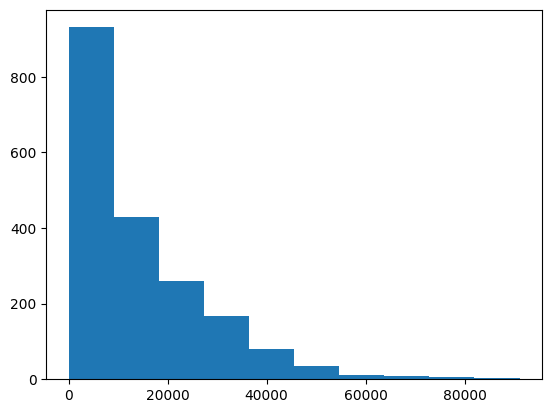

In [129]:
plt.hist(all_values)

In [ ]:
# test for many-days with the pretrained parameters
import numpy as np
import csv
import sys

def load_return(m, d):
    ## m: 前m公司
    ## d: date

    d = d - 1

    def load_csv_numeric(path):
        """
        读取 CSV，跳过首列日期，返回 numpy 数组 (float)
        """
        rows = []
        with open(path, "r") as f:
            reader = csv.reader(f)
            header = next(reader)  # 跳过表头
            for line in reader:
                # 从第 1 列开始转成 float
                rows.append([float(x) for x in line[1:]])
        return np.array(rows)

    def extract(data, m, d):
        """
        从 data 中提取第 d 天、前 m 个公司的数据（返回 1D numpy 数组）
        """
        return data[d, :m]

    # ===== 使用示例 =====
    # CSV 文件路径
    sys.path.append("../../")
    path = "../../data/returns.csv"

    # 读取数据
    data = load_csv_numeric(path)

    # 设置 m 和 d
    m = 5        # 前 5 个公司
    d = 2        # 第 2 天（从 0 开始）

    # 提取向量
    vector = extract(data, m, d)
    return vector

In [ ]:
sim = []

# for 100 days
for d in range(100):
    h = load_return(5, d + 1)
    max_energy, min_energy, min_energy_state = find_solution(h, J, C)

    v_list = []
    for x0 in sol_list:

        x = x0[0:p]
        y = x0[p:2 * p]

        param_dict = {}
        for i in range(p):
            param_dict[f'betas[{i}]'] = float(x[i])
            param_dict[f'gammas[{i}]'] = float(y[i])

        circ = QAOA_circuit(p, N, h, J)
        circ = circ.assign_parameters(param_dict, inplace=False)
        job = backend.run(circ, shots=shots)
        counts = job.result().get_counts()
        v = []

        for b in counts:
            count = counts[b]
            s = np.array([int(bit) for bit in b])[::-1]
            s = 1 - 2 * s  # Convert to +1/-1

            single_time_value = 0
            for i in range(N):
                single_time_value += h[i] * s[i]
            single_time_value += np.matmul(s, np.matmul(J, s))
            single_time_value = single_time_value + C

            v.extend([single_time_value] * count)

        v = np.array(v)
        v_list.append(v)


    all_data = v_list

    # 找出所有数组中出现过的整数
    all_values = np.unique(np.concatenate(all_data))

    # s_min = 
    sim.append(np.min(all_values) / min_energy)

plt.plot(sim)